In [1]:
data <- read.csv('dataTimeSeries.csv', dec = '.', sep =';')


In [2]:
str(data)

'data.frame':	153 obs. of  2 variables:
 $ Date: int  20150101 20150102 20150103 20150104 20150105 20150106 20150107 20150108 20150109 20150110 ...
 $ x   : num  5.64 18.16 18.87 15.44 14.12 ...


In [3]:
summary(data)

      Date                x         
 Min.   :20150101   Min.   : 3.414  
 1st Qu.:20150208   1st Qu.:15.617  
 Median :20150318   Median :19.084  
 Mean   :20150321   Mean   :19.593  
 3rd Qu.:20150425   3rd Qu.:24.235  
 Max.   :20150602   Max.   :36.167  

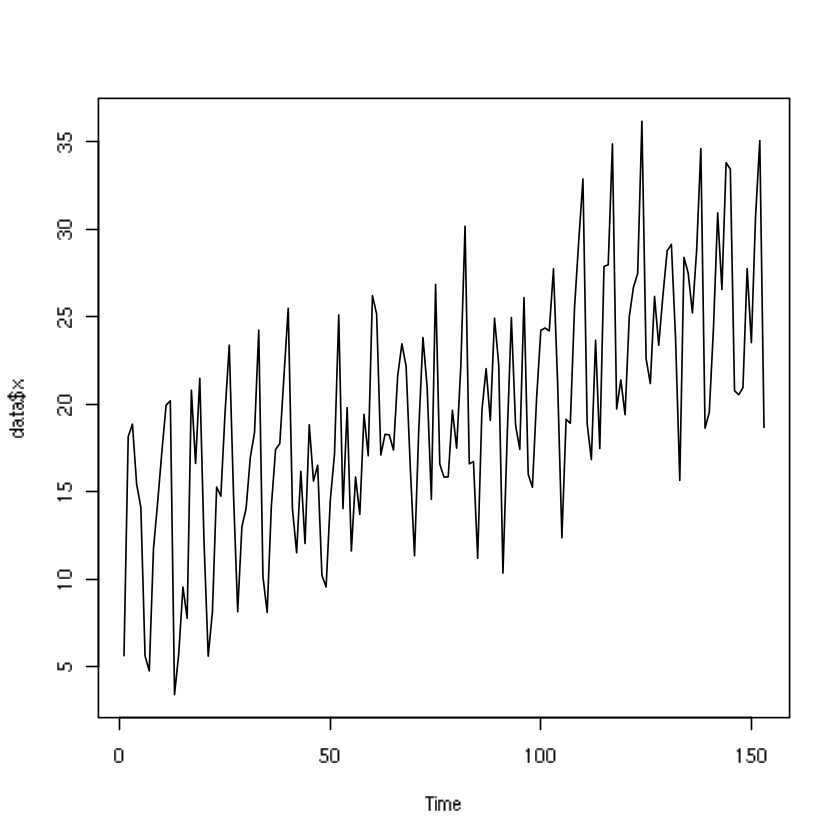

In [5]:
plot.ts(data$x)

In [6]:
?stl

# Seasonal Decomposition of Time Series by Loess

In [5]:
decomposition <- stl( ts(data$x, frequency = 7), s.window = 'periodic', inner = 2, robust = TRUE )

In [6]:
mtx_of_results <- decomposition$time.series


In [11]:
str(mtx_of_results)

 Time-Series [1:153, 1:3] from 1 to 22.7: -2.07 0.66 1.32 3.27 7.14 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:3] "seasonal" "trend" "remainder"


In [7]:
head(mtx_of_results)

seasonal,trend,remainder
-2.0690987,17.55844,-9.847301
0.6603982,16.37447,1.122831
1.3205557,15.19050,2.357520
3.2710488,14.25945,-2.087658
7.1375620,13.32840,-6.346959
-4.0938020,12.76418,-3.042243


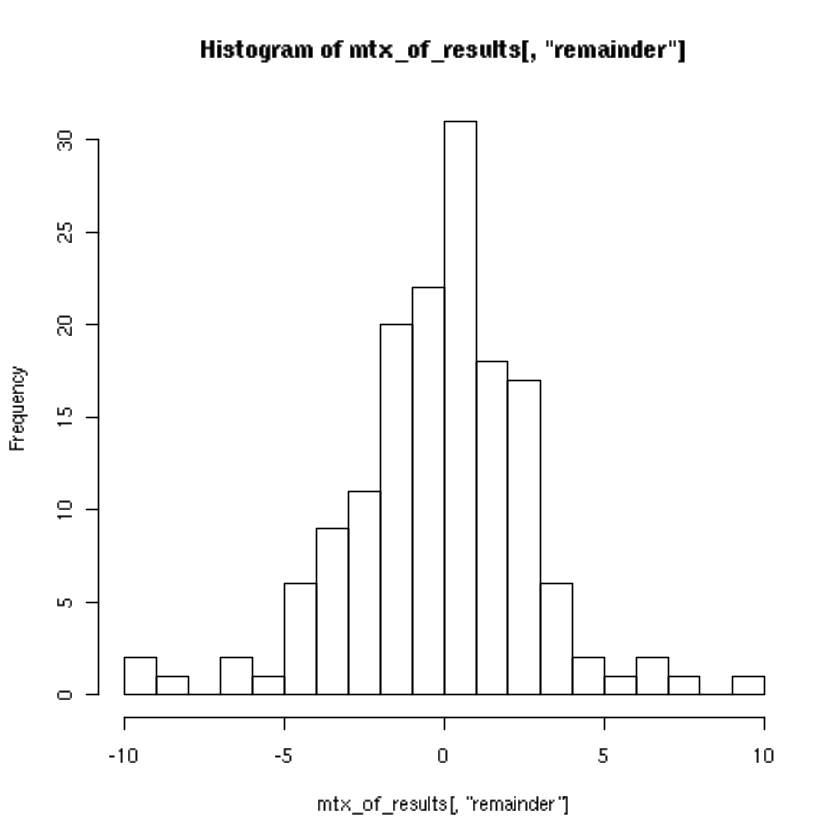

In [8]:
hist(mtx_of_results[,'remainder'],breaks = 'FD') # hist of residuals

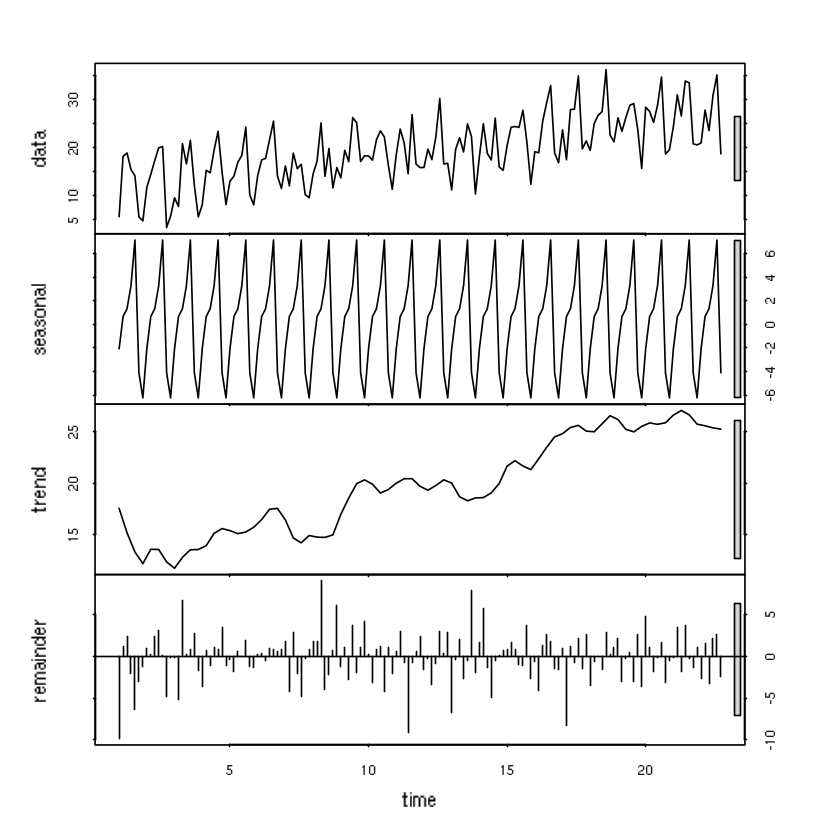

In [9]:
plot(decomposition)

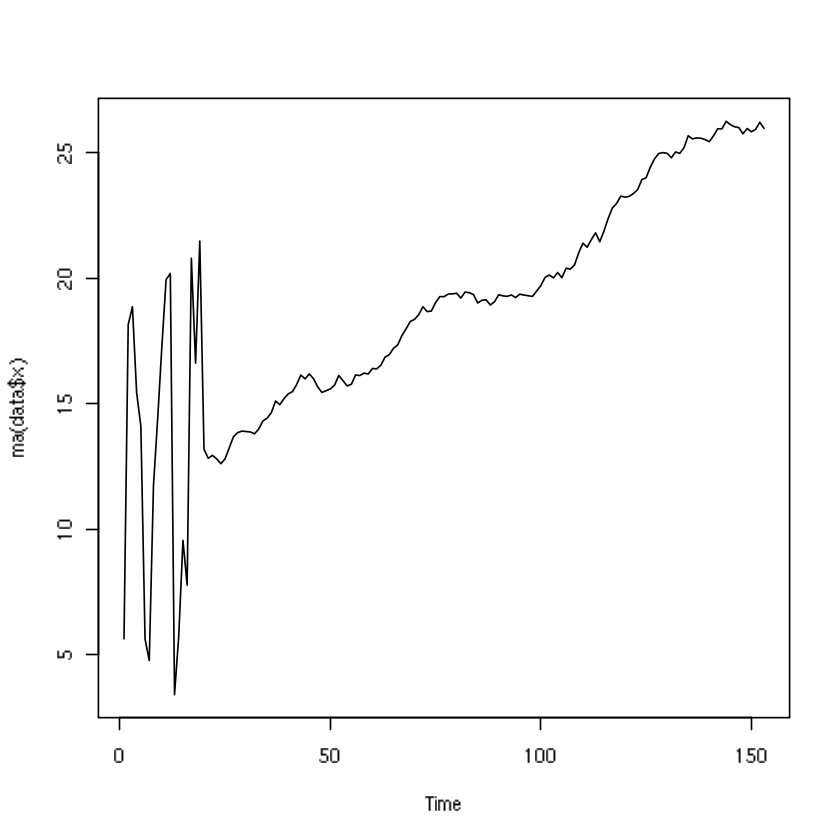

In [13]:
#Moving average
ma <- function(arr, n=20){
  res = arr
  for(i in n:length(arr)){
    res[i] = mean(arr[(i-n):i])
  }
  res
}
plot.ts(ma(data$x))


# Autocorrelation to determine sesonality

In [23]:
n <- length(data$x)


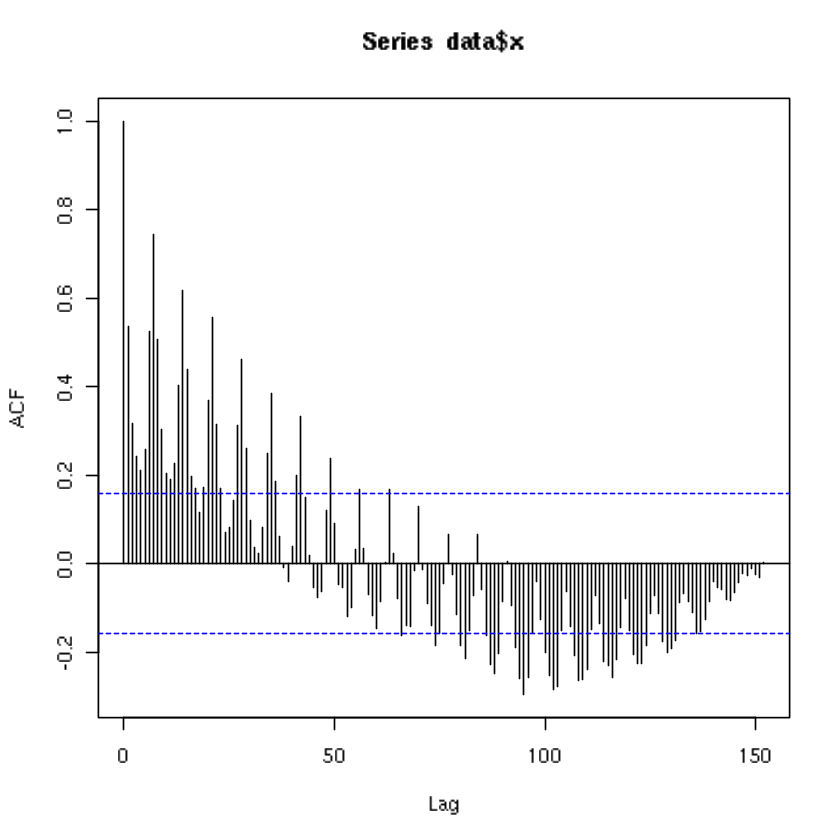

In [24]:
#with the trend
acf(data$x, lag.max = n, type = "correlation", plot= TRUE)

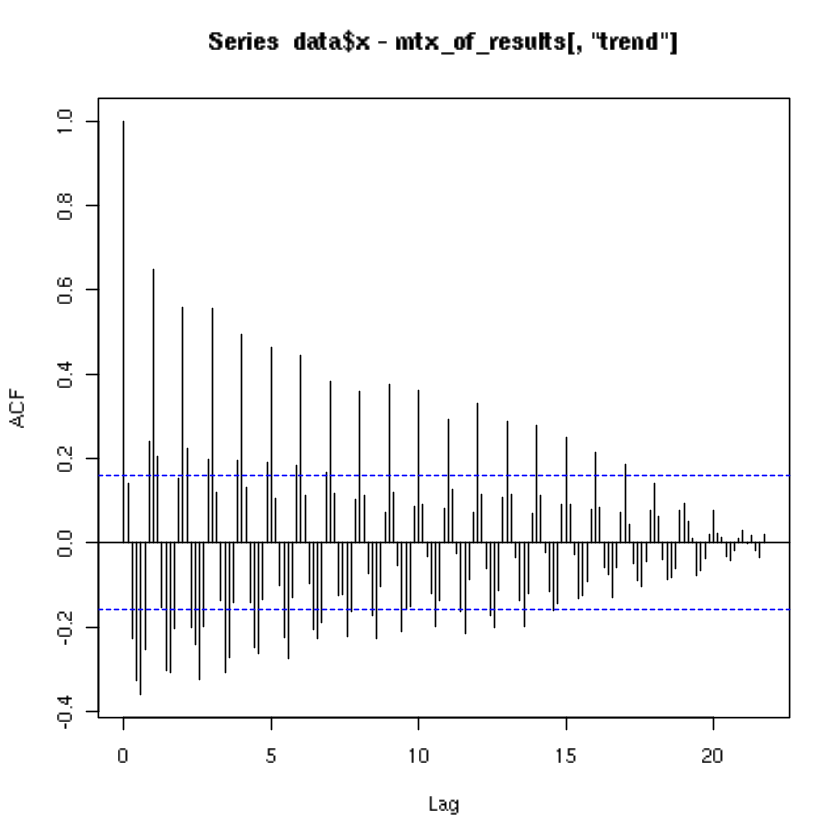

In [25]:
#without the trend
acf(data$x -mtx_of_results[,'trend'] , lag.max = n, type = "correlation", plot= TRUE)

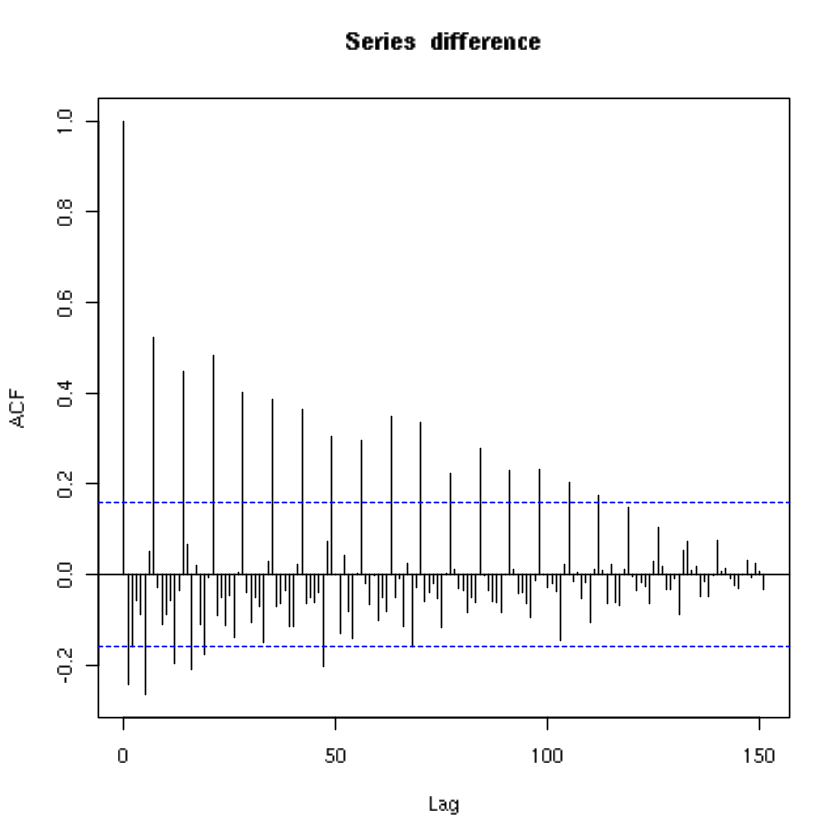

In [27]:
#removing trend by substraction neihbors
difference <- data$x[2:n] - data$x[1:n-1]
acf(difference, lag.max = n, type = "correlation", plot= TRUE)

In [28]:
#using different formula for autocorrelation (with trend)
corr_values <- vector()
lag <- seq(2, 152, 1) # difference in time between two realizations of the proccess
for (var in lag) {
    corr_values <- append(corr_values,  cor( data$x[1:(n - var)], data$x[(var + 1):n] ))
}


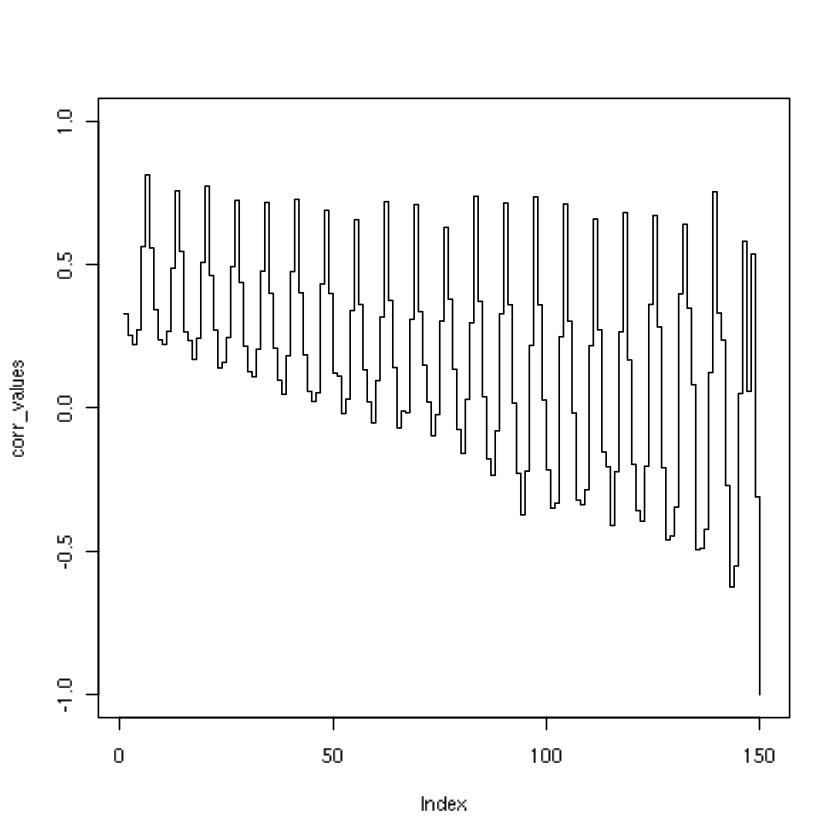

In [30]:
plot(corr_values, ylim=c(-1,1), cex = 0.5, type = "s")

In [35]:
m = length(difference)

In [38]:
#using different formula for autocorrelation (without trend)
corr_values1 <- vector()
lag1 <- seq(2, 151, 1) # difference in time between two realizations of the proccess
for (var in lag1) {
    corr_values1 <- append(corr_values1,  cor( difference[1:(m - var)], difference[(var + 1):m] ))
}


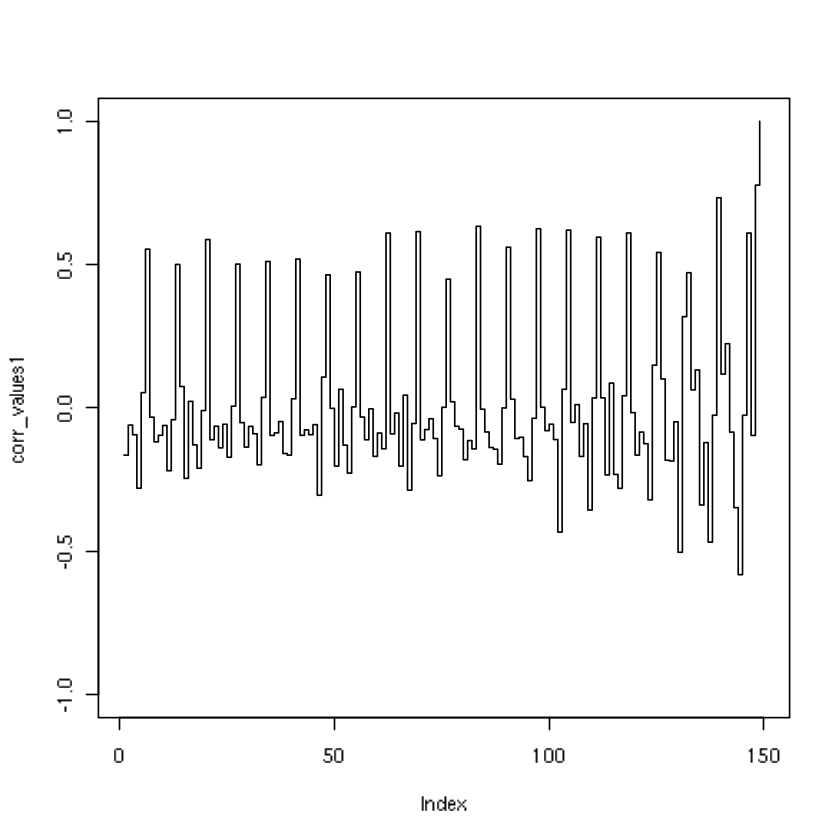

In [39]:
plot(corr_values1, ylim=c(-1,1), cex = 0.5, type = "s")

# Time Series Forecasting

In [18]:
training_data <- ts( head(data$x, nrow(data)- 30) ) # creating time series object

In [19]:
class(training_data)

[1] "ts"

In [48]:
test_data <- ts(tail(data$x, 30), start = nrow(data)- 30 + 1) # data used for predictions

In [24]:
#Fit Autoregressive Models to Time Series (yule-walker equations to estimate model's parameters)
auto_reg <- ar(training_data, aic = FALSE, order.max = 1)

In [29]:
auto_reg



Call:
ar(x = training_data, aic = FALSE, order.max = 1)

Coefficients:
     1  
0.4565  

Order selected 1  sigma^2 estimated as  29.76

In [32]:
forecast <- predict(auto_reg, n.ahead = 30) 

In [40]:
print(forecast)

$pred
Time Series:
Start = 124 
End = 153 
Frequency = 1 
 [1] 22.32835 19.97937 18.90715 18.41772 18.19432 18.09234 18.04579 18.02455
 [9] 18.01485 18.01042 18.00840 18.00748 18.00706 18.00686 18.00678 18.00674
[17] 18.00672 18.00671 18.00671 18.00670 18.00670 18.00670 18.00670 18.00670
[25] 18.00670 18.00670 18.00670 18.00670 18.00670 18.00670

$se
Time Series:
Start = 124 
End = 153 
Frequency = 1 
 [1] 5.455600 5.997085 6.103864 6.125877 6.130454 6.131407 6.131606 6.131647
 [9] 6.131656 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658
[17] 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658
[25] 6.131658 6.131658 6.131658 6.131658 6.131658 6.131658



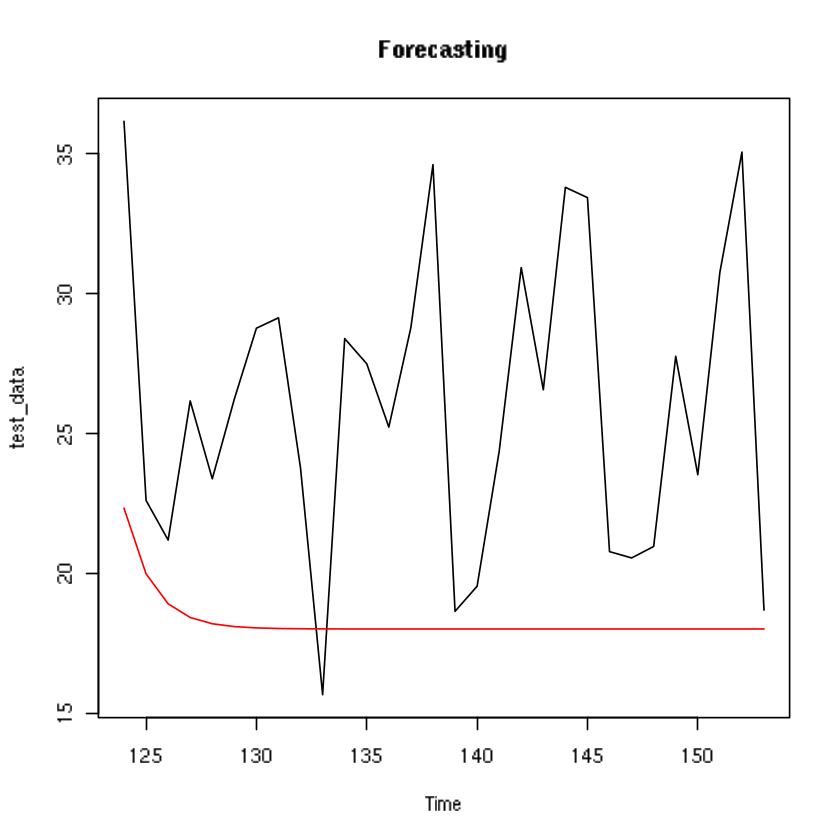

In [68]:
# Comparing predictions with the test data (order of regression is 1)

plot.ts(test_data, main = "Forecasting")
lines(forecast[[1]], col = 'red')


In [69]:
auto_reg1 <- ar(training_data, aic = TRUE) # the Akaike Information Criterion is used to choose the order of the autoregressive model


In [70]:
auto_reg1


Call:
ar(x = training_data, aic = TRUE)

Coefficients:
      1        2        3        4        5        6        7  
 0.1948   0.0506  -0.0196  -0.0077  -0.0855   0.2743   0.4508  

Order selected 7  sigma^2 estimated as  19.4

In [71]:
forecast1 <- predict(auto_reg1, n.ahead = 30) 

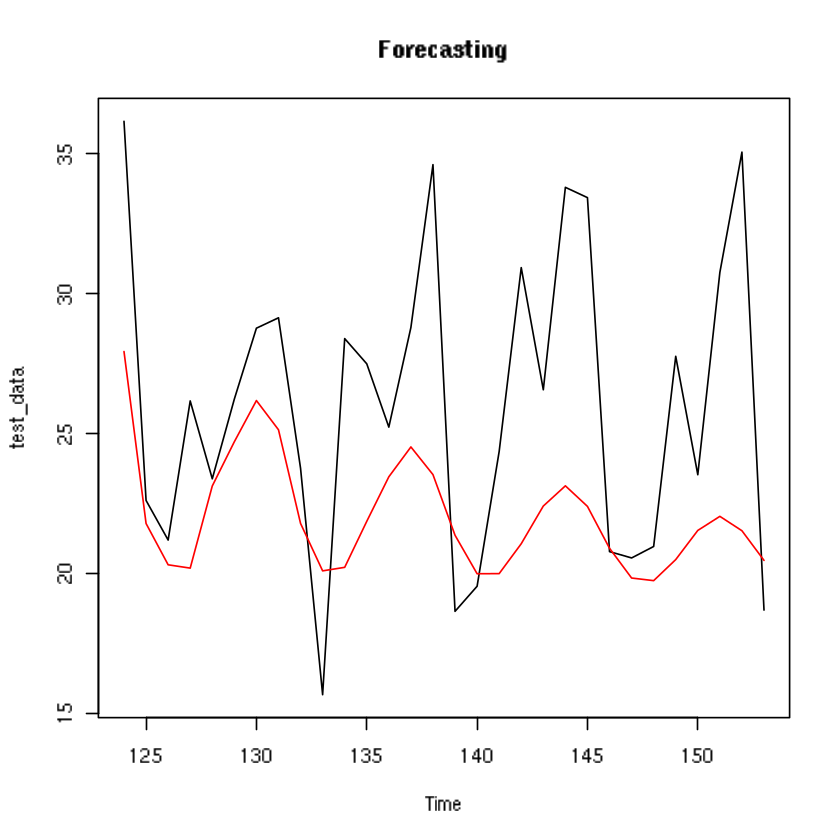

In [72]:
# Comparing predictions with the test data (AIC used to choose the order of autoregression)
plot.ts(test_data, main = "Forecasting")
lines(forecast1[[1]], col = 'red')
